### How Art and Language are tied together?
This is a vert quick and simple experiment to see how [Artsy's](artsy.net) ['art genes'](https://www.artsy.net/categories) just based on the textual description of the genes.

##### Background
Structuralists and Post-Structuralist beleive language and arts are both sign systems. In Hermeneutics, an 'artwork', similar to a 'word' gets its meaning through human interpretation. Nietzsche along with Deleuze and Guattari, believed language and art are mechanism of creating new concepts and ways of being. But aside from these theories, we know an artwork is such a fluid entity that by describing and interpreting it, becomes something different. It is interesting to investigate how the description of artworks are related to each other regardless of the artwork itself as an object to verify if the object 'becomes' its description.

##### Method
1. Load pre-trained word2vec embeding vectors (trained from Wikipedia + News)
2. Create a vector for each gene description from Artsy's API by adding up the embeding vector of each word in the description
3. Compare/Visualize genes

##### Usecase
With a good embedimg model it is possible to get similarity neighborhood of a gene, or add and subtract them similar to this [Game of Thrones embeding](https://medium.com/towards-data-science/game-of-thrones-word-embeddings-does-r-l-j-part-1-8ca70a8f1fad). 

This is just a quick experiment. 


In [67]:
from gensim.models import Word2Vec

#model = Word2Vec().load_word2vec_format("./GoogleNews-vectors-negative300.bin", binary=True)
model = Word2Vec().load_word2vec_format("./glove.6B.300d.txt")

In [68]:
model.most_similar("art", topn=10)

[('arts', 0.7138696312904358),
 ('museum', 0.684175968170166),
 ('paintings', 0.650521993637085),
 ('painting', 0.6487808227539062),
 ('gallery', 0.6464606523513794),
 ('sculpture', 0.6448274850845337),
 ('photography', 0.6387885212898254),
 ('contemporary', 0.6316169500350952),
 ('exhibition', 0.6165661811828613),
 ('artist', 0.6034246683120728)]

In [69]:
model.most_similar_cosmul(positive=["painting", "programming"], topn=5)

[('works', 0.4912715256214142),
 ('art', 0.4907427430152893),
 ('paintings', 0.4817741811275482),
 ('abstract', 0.47614383697509766),
 ('arts', 0.4670995771884918)]

In [70]:
import json

with open('../genes.json') as data_file:    
    genes = json.load(data_file)

print(len(genes))

1031


In [60]:
for i, gene in enumerate(genes):
    if i==0:
        print(gene["name"])

"Bad Painting"


In [61]:
from nltk import pos_tag, word_tokenize
from gensim import matutils
import numpy as np


def build_category_vector(category, i): 
    words = word_tokenize(category)
    words=[word.lower() for word in words if word.isalpha()]
    postags = pos_tag(words)
    vector = []
    for tag in postags:
        if tag[1] in ['NN', 'NNS', 'JJ', 'NNP', 'NNPS', 'NNDBN', 'VBG', 'CD']:  # Only keep meaningful words
            try:
                v = model[tag[0]]  # Get the word vector
                if v.any():
                    vector.append(v)
            except:
                print("Word not found in corpus: %s" % tag[0])
            tagset.append(tag[0])
    
    #print(vector, len(vector))
    #print(matutils.unitvec(np.array(vector).mean(axis=0)))
    if vector and len(vector)>0:
        return matutils.unitvec(np.array(vector).mean(axis=0))  # Average the vector
    else:
        print('returning zeros for ', len(vector), i, category)
        return np.zeros(300)


gene_vectors = []
tagset = []

# print('printing')
# print(genes[477])
# a = build_category_vector(genes[477]["description"], 477)
# print(a)

gene_names = []
for i, gene in enumerate(genes):
    #if i==0:
        print(gene["name"])
        if gene["description"]:
            gene_vectors.append(build_category_vector(gene["description"] , i))
            gene_names.append(gene["name"])
        #print(len(gene_vectors))

"Bad Painting"
'85 New Wave
1000–1400 CE
15th Century
Word not found in corpus: macchu
16th Century
17th Century
18th Century
1900–1917
1918–1939 (Interwar)
1940s–1950s
1960s
1970s
Word not found in corpus: postminimalism
1980s
1990s
19th Century
19th Century American Art
Word not found in corpus: ossawa
19th Century American Paintings and Works on Paper
19th Century French Academy
Word not found in corpus: gardeuse
19th Century German Realism
2000–present
20th Century Art
20th Century Furniture and Design
500–1000 CE
Word not found in corpus: abassid
Aboriginal Art
Abstract Art
Abstract Expressionism
Abstract Illusionism
Abstract Landscape
Abstract Painting
Abstract Photography
Abstract Sculpture
Abstract versus Figurative Art
Abstraction-Création
Action Painting
Adolescence
Advertising and Brands
Aerial View
Africa
African Diaspora
Word not found in corpus: wangechi
Afrofuturism
Album, Folio and Fan Formats
Allegory
Allover Composition
Altarpiece
Word not found in corpus: isenheim
Al

In [62]:
for i, gene_vector in enumerate(gene_vectors):
    if np.isnan(np.sum(gene_vector)):
        print(i, genes[i]['name'], gene_vector)


from sklearn.decomposition import PCA

X = np.array(gene_vectors)
print(len(X))
pca = PCA(n_components=2)
pca.fit(X)
pca_transform = pca.transform(X)

print(pca.explained_variance_ratio_)

#477 #595 #818

910
[ 0.10667413  0.07649864]


In [63]:
import pandas as pd

pca_df = pd.DataFrame(pca_transform)

#gene_names = map(lambda x: x['name'], genes)

#print(gene_names)
pca_df.index = gene_names
pca_df.columns = ['PC1','PC2']

pca_df.head()



,PC1,PC2
"""Bad Painting""",-0.052761,-0.180551
'85 New Wave,0.188180,-0.062048
1000–1400 CE,0.167496,0.078040
15th Century,-0.037573,-0.051456
16th Century,0.139529,-0.085734


In [64]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4)

clusters =kmeans.fit(X)
#y_pred = kmeans.predict(X)

pca_df['cluster'] = pd.Series(clusters.labels_, index=pca_df.index)



In [65]:
pca_df.to_csv('genes_pca.csv')

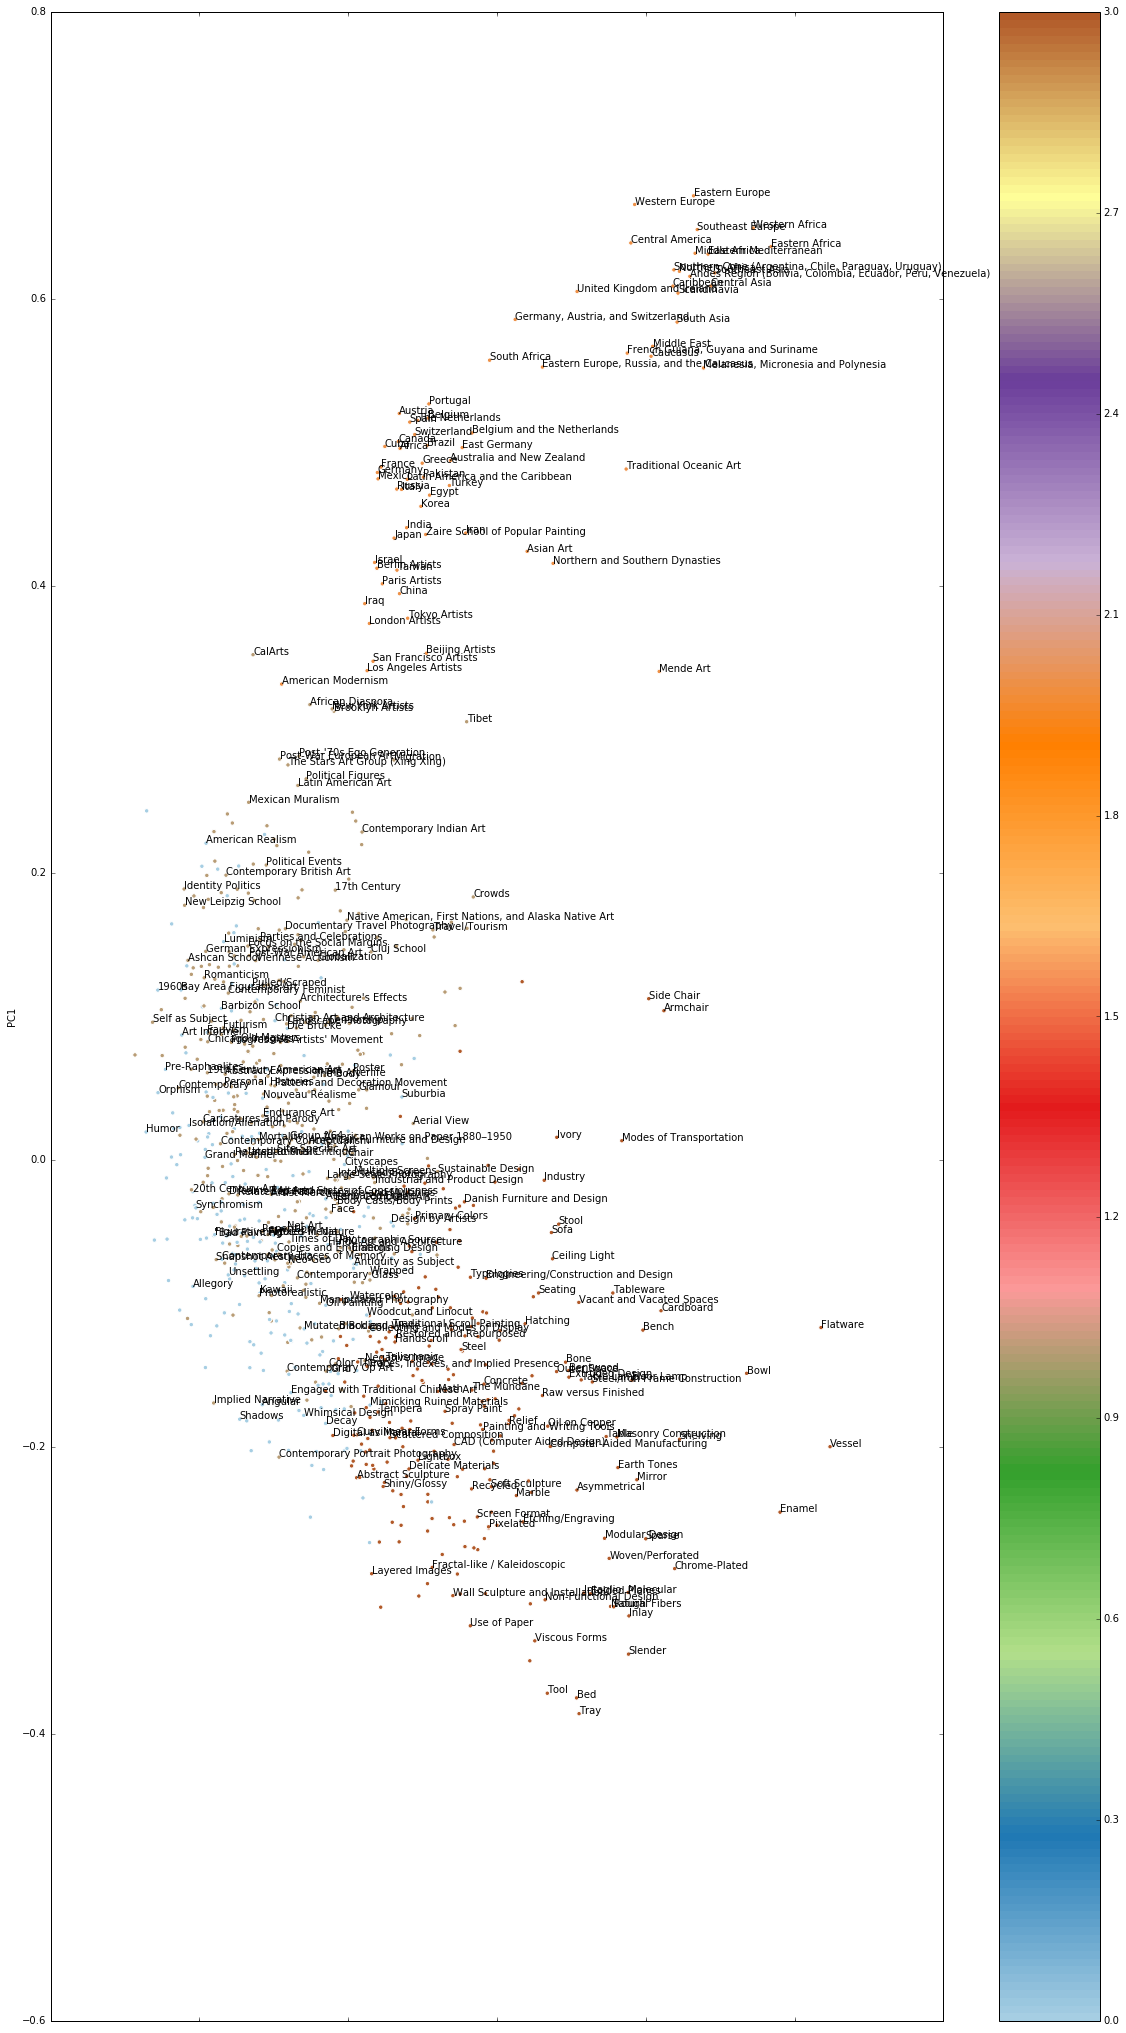

In [66]:
%matplotlib inline
import matplotlib.pyplot as plt

ax = pca_df.plot(kind='scatter', x='PC2', y='PC1', edgecolor='w',  c=pca_df.cluster.astype(np.float), cmap=plt.cm.Paired,  figsize=(20,36))

for i, gene_name in enumerate(pca_df.index):
    if (pca_df.iloc[i].PC1 > 0.25 or pca_df.iloc[i].PC2 > 0.25 ) or i % 5 == 0:
        ax.annotate(gene_name, (pca_df.iloc[i].PC2, pca_df.iloc[i].PC1))